In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sin, cos, sqrt, atan2, radians, sqrt
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error


/Users/prachi/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/prachi/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/prachi/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/prachi/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
train_df =  pd.read_csv('train.csv')
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [3]:
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5.542386e+07,5.542386e+07,5.542386e+07,5.542348e+07,5.542348e+07,5.542386e+07
mean,1.134505e+01,-7.250968e+01,3.991979e+01,-7.251121e+01,3.992068e+01,1.685380e+00
std,2.071083e+01,1.284888e+01,9.642353e+00,1.278220e+01,9.633346e+00,1.327664e+00
min,-3.000000e+02,-3.442060e+03,-3.492264e+03,-3.442025e+03,-3.547887e+03,0.000000e+00
25%,6.000000e+00,-7.399207e+01,4.073493e+01,-7.399140e+01,4.073403e+01,1.000000e+00
50%,8.500000e+00,-7.398180e+01,4.075265e+01,-7.398015e+01,4.075316e+01,1.000000e+00
75%,1.250000e+01,-7.396708e+01,4.076713e+01,-7.396367e+01,4.076810e+01,2.000000e+00
max,9.396336e+04,3.457626e+03,3.408790e+03,3.457622e+03,3.537133e+03,2.080000e+02


In [40]:
train_df = train_df.dropna(how="any", axis="rows")
train_df = train_df[train_df.fare_amount > 0]
train_df = train_df[(train_df.passenger_count > 0) & (train_df.passenger_count < 10)]
train_df = train_df[(train_df.pickup_latitude >= -90) & (train_df.pickup_latitude <= 90)]
train_df = train_df[(train_df.dropoff_latitude >= -90) & (train_df.dropoff_latitude <= 90)]
train_df = train_df[(train_df.pickup_longitude >= -180) & (train_df.pickup_longitude <= 180)]
train_df = train_df[(train_df.dropoff_longitude >= -180) & (train_df.dropoff_longitude <= 180)]

In [6]:
test_df =  pd.read_csv('test.csv')
test_df.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273
std,0.042774,0.033541,0.039072,0.035435,1.278747
min,-74.252193,40.573143,-74.263242,40.568973,1.000000
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000
max,-72.986532,41.709555,-72.990963,41.696683,6.000000


In [7]:
def add_travel_vector_features(df):
    df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    df['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()

In [8]:
def add_euclidean_distance_feature(df):
    df['euclidean_distance'] = np.sqrt((np.square(df.abs_diff_latitude) + np.square(df.abs_diff_longitude))) * 69 

In [9]:
def add_distance_travelled(df):
    R = 3959 # Radius of earth in miles
    phi1 = np.radians(df['pickup_latitude'])
    phi2 = np.radians(df['dropoff_latitude'])
    phi_chg = np.radians(df['pickup_latitude'] - df['dropoff_latitude'])
    delta_chg = np.radians(df['pickup_longitude'] - df['dropoff_longitude'])
    a = np.sin(phi_chg / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_chg/2)**2
    c = 2 * np.arcsin(a ** 0.5)
    d = R * c
    df['travel_distance'] = d

In [10]:
def process_pickup_time(df):
    df['pickup_datetime'] = df['pickup_datetime'].str.replace(" UTC", "")
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')

In [11]:
def add_date_time_features(df):
    df['hour_of_day'] = df.pickup_datetime.dt.hour
    df['week'] = df.pickup_datetime.dt.week
    df['month'] = df.pickup_datetime.dt.month
    df["year"] = df.pickup_datetime.dt.year
    df['day_of_year'] = df.pickup_datetime.dt.dayofyear
    df['week_of_year'] = df.pickup_datetime.dt.weekofyear
    df["weekday"] = df.pickup_datetime.dt.weekday
    df["quarter"] = df.pickup_datetime.dt.quarter
    df["day_of_month"] = df.pickup_datetime.dt.day

In [12]:
add_travel_vector_features(train_df)
add_euclidean_distance_feature(train_df)
add_distance_travelled(train_df)
process_pickup_time(train_df)
add_date_time_features(train_df)

In [13]:
add_travel_vector_features(test_df)
add_euclidean_distance_feature(test_df)
add_distance_travelled(test_df)
process_pickup_time(test_df)
add_date_time_features(test_df)

In [14]:
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude,euclidean_distance,travel_distance,hour_of_day,week,month,year,day_of_year,week_of_year,weekday,quarter,day_of_month
count,5.522188e+07,5.522188e+07,5.522188e+07,5.522188e+07,5.522188e+07,5.522188e+07,5.522188e+07,5.522188e+07,5.522188e+07,5.522188e+07,5.522188e+07,5.522188e+07,5.522188e+07,5.522188e+07,5.522188e+07,5.522188e+07,5.522188e+07,5.522188e+07,5.522188e+07
mean,1.135454e+01,-7.249841e+01,3.991746e+01,-7.250319e+01,3.991994e+01,1.691332e+00,1.624532e-01,9.242677e-02,1.341127e+01,1.208558e+01,1.350935e+01,2.545825e+01,6.267966e+00,2.011741e+03,1.752674e+02,2.545825e+01,3.041397e+00,2.423035e+00,1.571500e+01
std,2.074353e+01,1.045618e+01,6.114484e+00,1.043703e+01,6.107355e+00,1.326183e+00,3.206340e+00,1.700811e+00,2.504095e+02,2.276798e+02,6.518209e+00,1.494136e+01,3.435159e+00,1.862839e+00,1.047583e+02,1.494136e+01,1.948965e+00,1.115403e+00,8.684342e+00
min,1.000000e-02,-1.717973e+02,-7.783387e+01,-1.739576e+02,-7.435461e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,2.009000e+03,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
25%,6.000000e+00,-7.399207e+01,4.073493e+01,-7.399140e+01,4.073403e+01,1.000000e+00,5.804000e-03,6.585000e-03,8.550535e-01,7.535405e-01,9.000000e+00,1.300000e+01,3.000000e+00,2.010000e+03,8.500000e+01,1.300000e+01,1.000000e+00,1.000000e+00,8.000000e+00
50%,8.500000e+00,-7.398180e+01,4.075265e+01,-7.398015e+01,4.075315e+01,1.000000e+00,1.243600e-02,1.386200e-02,1.479347e+00,1.315587e+00,1.400000e+01,2.400000e+01,6.000000e+00,2.012000e+03,1.670000e+02,2.400000e+01,3.000000e+00,2.000000e+00,1.600000e+01
75%,1.250000e+01,-7.396708e+01,4.076713e+01,-7.396367e+01,4.076810e+01,2.000000e+00,2.372200e-02,2.694000e-02,2.646496e+00,2.409023e+00,1.900000e+01,3.900000e+01,9.000000e+00,2.013000e+03,2.670000e+02,3.900000e+01,5.000000e+00,3.000000e+00,2.300000e+01
max,9.396336e+04,1.699728e+02,8.974216e+01,1.699728e+02,8.981667e+01,2.080000e+02,2.290003e+02,1.185963e+02,1.590853e+04,1.223481e+04,2.300000e+01,5.300000e+01,1.200000e+01,2.015000e+03,3.660000e+02,5.300000e+01,6.000000e+00,4.000000e+00,3.100000e+01


In [15]:
test_df.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude,euclidean_distance,travel_distance,hour_of_day,week,month,year,day_of_year,week_of_year,weekday,quarter,day_of_month
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273,0.023348,0.022133,2.425100,2.134772,13.467420,28.161892,6.857979,2011.815816,193.668247,28.161892,2.852834,2.573532,16.194170
std,0.042774,0.033541,0.039072,0.035435,1.278747,0.036719,0.025589,2.929692,2.468471,6.868584,14.523575,3.353272,1.803347,101.853030,14.523575,1.994451,1.097069,8.838482
min,-74.252193,40.573143,-74.263242,40.568973,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2009.000000,1.000000,1.000000,0.000000,1.000000,1.000000
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000,0.006354,0.007279,0.915005,0.806762,8.000000,17.000000,4.000000,2010.000000,115.000000,17.000000,1.000000,2.000000,9.000000
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000,0.013123,0.014715,1.547201,1.377921,15.000000,29.000000,7.000000,2012.000000,195.000000,29.000000,3.000000,3.000000,16.000000
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000,0.024557,0.028261,2.771750,2.513789,19.000000,40.000000,10.000000,2014.000000,277.000000,40.000000,5.000000,4.000000,25.000000
max,-72.986532,41.709555,-72.990963,41.696683,6.000000,0.849168,0.633213,72.955800,62.138491,23.000000,53.000000,12.000000,2015.000000,365.000000,53.000000,6.000000,4.000000,31.000000


In [17]:
train_df = train_df[(train_df.pickup_latitude >= 40.5) & (train_df.pickup_latitude <= 42)]
train_df = train_df[(train_df.dropoff_latitude >= 40.5) & (train_df.dropoff_latitude <= 42)]
train_df = train_df[(train_df.pickup_longitude >= -75) & (train_df.pickup_longitude <= -72.5)]
train_df = train_df[(train_df.dropoff_longitude >= -75) & (train_df.dropoff_longitude <= -72.5)]

In [22]:
train_df = train_df[(train_df.euclidean_distance < 73) & (train_df.travel_distance < 63)]

In [24]:
train_df = train_df[train_df.fare_amount < 600]

In [26]:
(train_df.euclidean_distance).corr(train_df.fare_amount)

0.8398104304118515

In [27]:
(train_df.hour_of_day).corr(train_df.travel_distance)

-0.02802679151920378

In [28]:
(train_df.hour_of_day).corr(train_df.fare_amount)

-0.017250219481352528

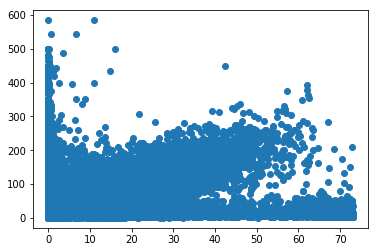

In [25]:
plt.scatter(x=train_df['euclidean_distance'], y=train_df['fare_amount'])

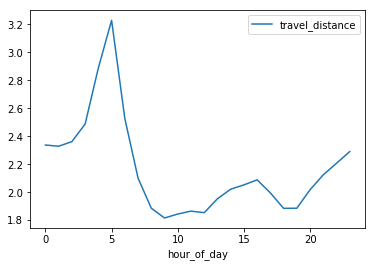

In [29]:
df = train_df.groupby('hour_of_day', as_index=False)['travel_distance'].mean()
df.plot(x = 'hour_of_day', y = 'travel_distance')

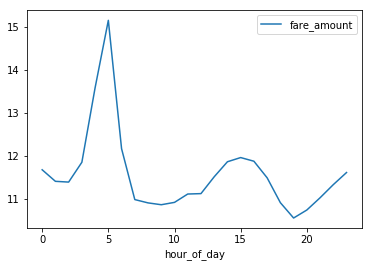

In [30]:
df2 = train_df.groupby('hour_of_day', as_index=False)['fare_amount'].mean()
df2.plot(x = 'hour_of_day', y = 'fare_amount')

In [31]:
(train_df.travel_distance).corr(train_df.fare_amount)

0.8316390736036909

In [32]:
(train_df.passenger_count).corr(train_df.fare_amount)

0.012935234154305473

In [33]:
(train_df.weekday).corr(train_df.fare_amount)

0.00299031405646563

In [34]:
(train_df.year).corr(train_df.fare_amount)

0.11573795628288101

In [35]:
(train_df.month).corr(train_df.fare_amount)

0.02407913388474672

In [41]:
(train_df.week).corr(train_df.fare_amount)

0.024009610347438485

In [42]:
(train_df.week_of_year).corr(train_df.fare_amount)

0.024009610347438485

In [43]:
(train_df.day_of_year).corr(train_df.fare_amount)

0.024078874681040575

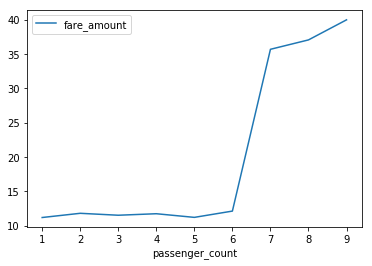

In [44]:
df2 = train_df.groupby('passenger_count', as_index=False)['fare_amount'].mean()
df2.plot(x = 'passenger_count', y = 'fare_amount')

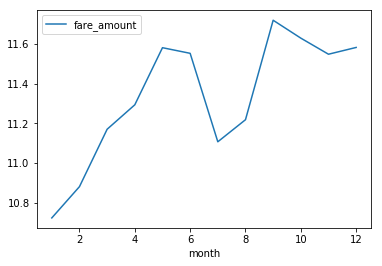

In [45]:
df = train_df.groupby('month', as_index=False)['fare_amount'].mean()
df.plot(x = 'month', y = 'fare_amount')

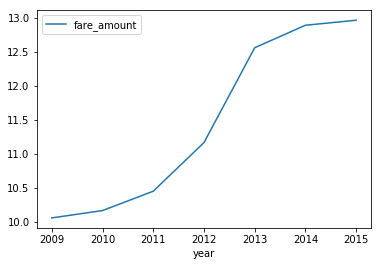

In [46]:
df = train_df.groupby('year', as_index=False)['fare_amount'].mean()
df.plot(x = 'year', y = 'fare_amount')

In [47]:
def add_distance_from_pickup_point_to_airport(df, airport_lat, airport_lon, pickup_airport_id):
    R = 3959 # Radius of earth in miles
    phi1 = np.radians(df['pickup_latitude'])
    phi2 = np.radians(airport_lat)
    phi_chg = np.radians(df['pickup_latitude'] - airport_lat)
    delta_chg = np.radians(df['pickup_longitude'] - airport_lon)
    a = np.sin(phi_chg / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_chg/2)**2
    c = 2 * np.arcsin(a ** 0.5)
    d = R * c
    df[pickup_airport_id] = d

In [48]:
def add_distance_from_dropoff_point_to_airport(df, airport_lat, airport_lon, pickup_airport_id):
    R = 3959 # Radius of earth in miles
    phi1 = np.radians(df['dropoff_latitude'])
    phi2 = np.radians(airport_lat)
    phi_chg = np.radians(df['dropoff_latitude'] - airport_lat)
    delta_chg = np.radians(df['dropoff_longitude'] - airport_lon)
    a = np.sin(phi_chg / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_chg/2)**2
    c = 2 * np.arcsin(a ** 0.5)
    d = R * c
    df[pickup_airport_id] = d

In [51]:
add_distance_from_pickup_point_to_airport(train_df, 40.6413, -73.7781, "pickup_distance_jfk")
add_distance_from_dropoff_point_to_airport(train_df, 40.6413, -73.7781, "dropoff_distance_jfk")

In [52]:
(train_df.pickup_distance_jfk).corr(train_df.fare_amount)

-0.38519998724072096

In [53]:
(train_df.dropoff_distance_jfk).corr(train_df.fare_amount)

-0.23911216566544846

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1b5723aa20>]],
      dtype=object)

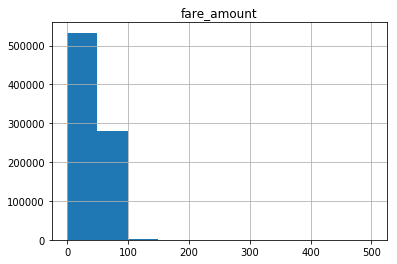

In [87]:
df = train_df[train_df.pickup_distance_jfk < 1.5]
df.hist(column = 'fare_amount', bins = 10)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1b5a20fd68>]],
      dtype=object)

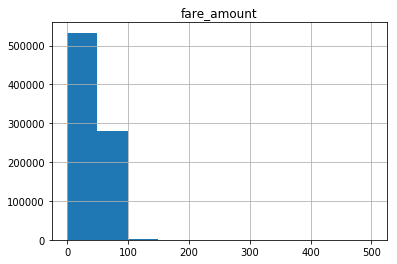

In [88]:
df5  = train_df[(train_df.pickup_distance_jfk < 1.5) & (train_df.dropoff_distance_jfk <= 20)]
df5.hist(column = 'fare_amount', bins = 10)

In [54]:
train_features = train_df[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'euclidean_distance', 'travel_distance','hour_of_day','passenger_count', 'month', 'year', 'pickup_distance_jfk', 'dropoff_distance_jfk']].copy()

In [55]:
x = train_features.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
normalized_train_features = pd.DataFrame(x_scaled)

In [56]:
fares = train_df.fare_amount

In [57]:
lm = linear_model.LinearRegression()
model = lm.fit(normalized_train_features, fares)
predictions = lm.predict(normalized_train_features)

In [58]:
predictions[0:10]

array([ 6.42782798, 16.71536049,  6.95650448,  8.98752257,  6.88183973,
       10.61790745,  7.70510211, 13.56542154,  7.8915243 ,  8.23172253])

In [59]:
lm.score(normalized_train_features, fares)

0.7324433621665225

In [62]:
lm.coef_

array([ 9.28271265e+01, -1.23938629e+02, -1.12541071e+02,  1.35495597e+02,
        2.71486738e+02, -6.71238316e+01,  2.29103587e-01,  2.40054388e-01,
        7.96361780e-01,  3.08431459e+00, -1.69882788e+02,  1.62705356e+02])

In [67]:
rms = sqrt(mean_squared_error(fares, predictions))

In [68]:
rms

5.003705043272599

In [60]:
add_distance_from_pickup_point_to_airport(test_df, 40.6413, -73.7781, "pickup_distance_jfk")
add_distance_from_dropoff_point_to_airport(test_df, 40.6413, -73.7781, "dropoff_distance_jfk")

In [61]:

min_max_scaler = preprocessing.MinMaxScaler(test_features = test_df[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'euclidean_distance', 'travel_distance','hour_of_day','passenger_count', 'month', 'year', 'pickup_distance_jfk', 'dropoff_distance_jfk']].copy())
y_scaled = min_max_scaler.fit_transform(test_features.values)
normalized_test_features = pd.DataFrame(y_scaled)
test_fares = lm.predict(normalized_test_features)
test_fares[0:10]

array([ 8.50017951,  8.5070998 ,  4.34262351,  7.04578957, 12.58682601,
        9.64699511,  4.81363068, 46.17763648,  9.43942881,  5.94739326])

In [73]:
train_features = train_features.drop(train_features.index[1000000: 54054199])

In [74]:
fares = fares.drop(fares.index[1000000: 54054199])

In [72]:
model =  RandomForestRegressor(n_estimators = 50)

In [75]:
model.fit(train_features.values,fares)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [82]:
model.predict(train_features.values)

array([ 5.783, 17.036,  5.544, ...,  4.55 , 10.864, 17.396])

In [83]:
model.score(train_features, fares)

0.9770927946822361

In [85]:
model.predict(test_features)

array([10.94  , 10.11  ,  4.406 , ..., 49.9466, 18.04  ,  7.9   ])

In [86]:
submission = pd.DataFrame(
    {'key': test_df.key, 'fare_amount': test_fares},
    columns = ['key', 'fare_amount'])
submission.to_csv('submission.csv', index = False)